# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**&#x1f600;
Predict the status of a genetic biomarker important for brain cancer treatment

※ Japanese version is here.

https://www.kaggle.com/chumajin/brain-tumor-eda-for-starter-version

## I think this competition is a competition that predicts the methylation of the MGMT promoter, which is an important gene biomarker for the treatment of brain tumors, from MRI images.

I think this sentence is difficult to understand for like me who is not specialist.

It seems that it has been reported that the response and prognosis to chemotherapy differ depending on the methylation status of the promoter region of the gene called MGMT.

Recently, by referring to this methylation test, it is possible to properly select radiation therapy or chemotherapy as postoperative treatment, which prolongs the survival period while maintaining the patient's condition well. It seems that it has been found to be useful for.

※ ref(Japanese) : https://www.h.u-tokyo.ac.jp/neurosurg/rinsho/noushu.htm 

At first I thought it was a competition to guess whether it was a brain tumor.
But this is misunderstanding (commented in English, thank you so much.).


All the subjects in this dataset seem to have a brain tumor. 
Class 0 refers to people who do not have the methylation of the MGMT promoter. Class 1 seems to be someone who has the methylation of the MGMT promoter. It is a competition that gives the probability of it.

## If you find it useful, I would be grateful if you could upvote it.
　
 
 ※　Thank you to those who have uploaded to my notebook before.
  
  
  ※ Before ver3, I made a mistake. Thank you for pointing out (@mpwolke, @giemmecci).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# 1. What to predict ?? (Let's see from submission.csv)

In [2]:
sample = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")
sample

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


* BraTS21ID is the patient's Id,

* Class 0 refers to people who do not have the methylation of the MGMT promoter. 

* Class 1 seems to be someone who has the methylation of the MGMT promoter. 

# 2. What to predict from ? Let's look from train.csv

## 2.1 Train.csv file structure

### There is no test.csv, so let's take a look at train.csv.

In [3]:
train = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


Almost the same information as submission.csv. 

BraTS21ID contains the patient's Id and MGMT_value contains information on whether the MGMT promoter has methylation.


This train data has FLAIR, T1w, T1wCE, and T2w, respectively, as shown below, and the dcm file is hung in them.

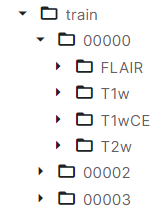


FLAIR, T1w, T1wCE, T2w are linked to each ID.

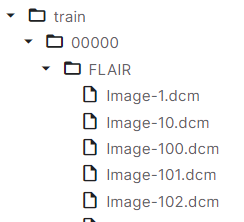


Each has a lot of dcm files.

## 2.2 Let's take a look at one dcm file.

To see what a dcm file looks like, firstly I opened one dcm file.

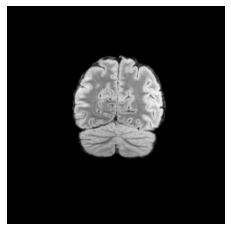

In [4]:
import pydicom
import matplotlib.pyplot as plt

dataset = pydicom.filereader.dcmread('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-109.dcm')
img = dataset.pixel_array

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_axis_off()
plt.show()

I made it a function only where it is made into img. (I will use it later)

In [5]:
def makeimg(path):
    dataset = pydicom.filereader.dcmread(path)
    img = dataset.pixel_array
    return img

## 2.3 Let's look at typical examples of images of FLAIR, T1w, T1wCE, and T2w.

After issuing the path, use this function to see typical examples of FLAIR, T1w, T1wCE, and T2w images.


Before that, I made sure whether the same number of dcm files in each folder or not.

## 2.3.1 Create dcm folder path

First, let's think about putting out the path of the dcm image.

In [6]:
train["imfolder"] = ['{0:05d}'.format(s) for s in train["BraTS21ID"]]
train

,BraTS21ID,MGMT_value,imfolder
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
...,...,...,...
580,1005,1,01005
581,1007,1,01007
582,1008,1,01008
583,1009,0,01009


In [7]:
train_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

train["path"] = [os.path.join(train_path,s) for s in train["imfolder"]  ]
train

,BraTS21ID,MGMT_value,imfolder,path
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...
...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...


If you list it as Scans, it will be easier to turn it with a for statement.

In [8]:
Scans = ["FLAIR","T1w","T1wCE","T2w"]

## 2.3.2 Check the number of dcm files

In the first place, check whether the number of dcm of these Scans is the same for each patient.

In [9]:
from tqdm import tqdm

In [10]:
allres = []

for num,path in tqdm(enumerate(train["path"])):
    for scan in Scans:
        folderpath = os.path.join(path,scan)
        filelist = os.listdir(folderpath)
        allres.append([train["BraTS21ID"].iloc[num],scan,len(filelist)])


585it [00:58, 10.08it/s]


In [11]:
allnumdf = pd.DataFrame(allres)
allnumdf.columns=["BraTS21Id","scan","count"]
allnumdf

,BraTS21Id,scan,count
0,0,FLAIR,400
1,0,T1w,33
2,0,T1wCE,129
3,0,T2w,408
4,2,FLAIR,129
...,...,...,...
2335,1009,T2w,23
2336,1010,FLAIR,60
2337,1010,T1w,192
2338,1010,T1wCE,187


Process it nicely and merge

In [12]:
tmpdf = allnumdf[allnumdf["scan"]=="FLAIR"].reset_index(drop=True)
tmpdf

,BraTS21Id,scan,count
0,0,FLAIR,400
1,2,FLAIR,129
2,3,FLAIR,129
3,5,FLAIR,400
4,6,FLAIR,129
...,...,...,...
580,1005,FLAIR,23
581,1007,FLAIR,124
582,1008,FLAIR,60
583,1009,FLAIR,23


In [13]:
train["FLAIR_count"] = tmpdf["count"]
train

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129
...,...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...,60
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...,23


Make this a for statement and add all

In [14]:
for scan in Scans:
    tmpdf = allnumdf[allnumdf["scan"]==scan].reset_index(drop=True)
    train[scan + "_count"] = tmpdf["count"]

In [15]:
train

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,33,129,408
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,31,129,384
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,33,129,408
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,28,129,424
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,129,408
...,...,...,...,...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,64
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23


You can see that some IDs are the same and some are different.

Check if they are all the same

In [16]:
allsame = [train["FLAIR_count"].iloc[s] ==   train["T1w_count"].iloc[s] ==train["T1wCE_count"].iloc[s] ==train["T2w_count"].iloc[s] 
          for s in range(len(train))]

In [17]:
train["allsame"] = allsame
train

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,33,129,408,False
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,31,129,384,False
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,33,129,408,False
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,28,129,424,False
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,129,408,False
...,...,...,...,...,...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124,True
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,64,False
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True


True is treated as 1, so you can see how many True there are by adding them.

In [18]:
train["allsame"].sum()

63

In [19]:
train["allsame"].sum()/len(train) * 100

10.76923076923077

It was confirmed that 585 patient ids had the same number of 63 patient ids (about 10%).



## 2.4 Deepen your understanding by looking at the images of people who have the same number of images

For an easy-to-understand image, let's try a person who has all the images.


Moreover, let's look at the images of MGMT_value is 1 or 0 in each.

In [20]:
train[train["allsame"]]

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame
64,100,1,00100,../input/rsna-miccai-brain-tumor-radiogenomic-...,22,22,22,22,True
65,102,0,00102,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
68,106,1,00106,../input/rsna-miccai-brain-tumor-radiogenomic-...,28,28,28,28,True
74,112,0,00112,../input/rsna-miccai-brain-tumor-radiogenomic-...,24,24,24,24,True
75,113,0,00113,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
...,...,...,...,...,...,...,...,...,...
577,1002,1,01002,../input/rsna-miccai-brain-tumor-radiogenomic-...,24,24,24,24,True
578,1003,1,01003,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124,True


The person with ID 100 on line 64 : MGMT_values 1(the person with the methylation of the MGMT promoter) and


Let's take a look at all the images of the person with ID 102 : MGMT_values 0 (the person who does not have) on the 65th line.


**First, do the person on line 64, then make it a function to see the person on line 65.**

In [21]:
row_ID = 64

In [22]:
train["BraTS21ID"].iloc[row_ID]

100

In [23]:
temp_folder = train["path"].iloc[row_ID]
temp_folder

'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00100'

I will list the paths. First with FLAIR.

In [24]:
temp_folder2 = os.path.join(temp_folder,"FLAIR")
temp_files = os.listdir(temp_folder2)
temp_files[:3]

['Image-4.dcm', 'Image-2.dcm', 'Image-3.dcm']

Save the numbers in the file names here so that you can sort them properly later.

In [25]:
imagenum = [s.split("-")[1] for s in temp_files]
imagenum = [s.split(".")[0] for s in imagenum]
imagenum[:3]

['4', '2', '3']

Give a dcm pass

In [26]:
temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
temp_path[:3]

['../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00100/FLAIR/Image-4.dcm',
 '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00100/FLAIR/Image-2.dcm',
 '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00100/FLAIR/Image-3.dcm']

Sort by dataframe.

In [27]:
tempdf = pd.DataFrame()
tempdf["image_num"] = imagenum
tempdf["image_num"] = tempdf["image_num"].astype("int")

tempdf["temp_path"] = temp_path

Use image_num to sort them neatly. It is important to make it an int type with ↑ and make it a number. As shown in the picture below, if you line up like the usual 1.dcm → 10.dcm, the time series will collapse.

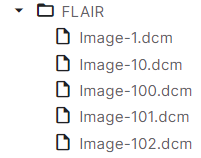

In [28]:
tempdf.head(3)

,image_num,temp_path
0,4,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [29]:
tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
tempdf.head(3)

,image_num,temp_path
0,1,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,../input/rsna-miccai-brain-tumor-radiogenomic-...


Stored in finpath.

In [30]:
finpath = tempdf["temp_path"]

Make these functions (the function looks long, but I just copied the code of the person on line 64 of ↑ to this point and made FLAIR the expression scan).Turn the list of Scans with a for statement, and with this, you can put out other than FLAIR at once

In [31]:
def makepath(row_ID,scan):
    
    temp_folder = train["path"].iloc[row_ID]
    temp_folder2 = os.path.join(temp_folder,scan)
    temp_files = os.listdir(temp_folder2)
    imagenum = [s.split("-")[1] for s in temp_files]
    imagenum = [s.split(".")[0] for s in imagenum]
    temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
    tempdf = pd.DataFrame()
    tempdf["image_num"] = imagenum
    tempdf["image_num"] = tempdf["image_num"].astype("int")
    tempdf["temp_path"] = temp_path
    tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
    finpath = tempdf["temp_path"]
    return finpath

In [32]:
Scans

['FLAIR', 'T1w', 'T1wCE', 'T2w']

Create a list of row Ids (you can make it a dataframe because you know the same number, you can't do anything else)

In [33]:
row_id=64

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [34]:
sampledf.head(3)

,FLAIR_path,T1w_path,T1wCE_path,T2w_path
0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


## **The one with MGMT_value = 1**
## Visualize the person with gene methylation = people with favorable prognostic factors and strong predictors of responsiveness to chemotherapy

MGMT_value = 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


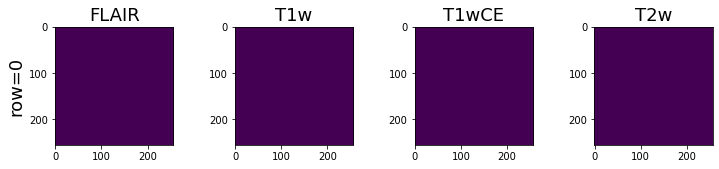

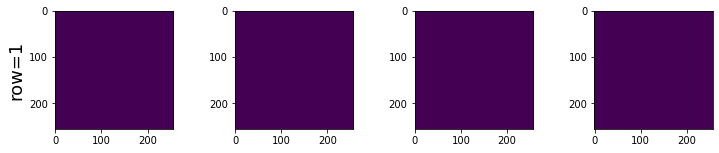

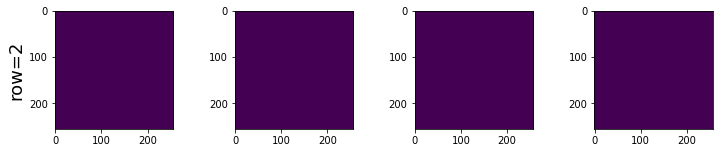

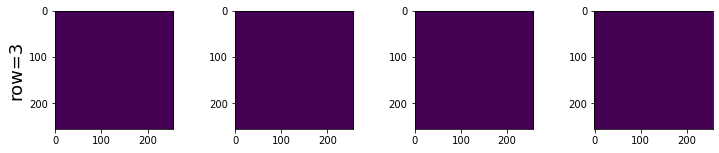

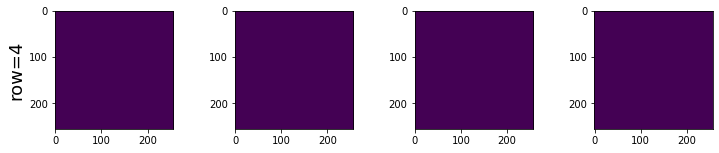

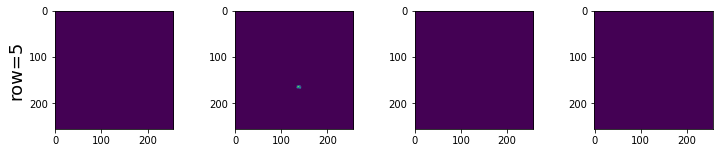

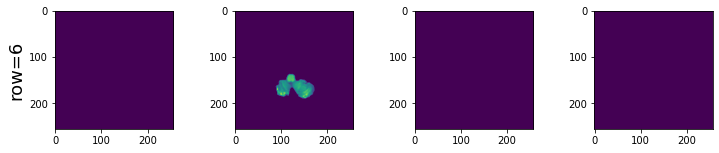

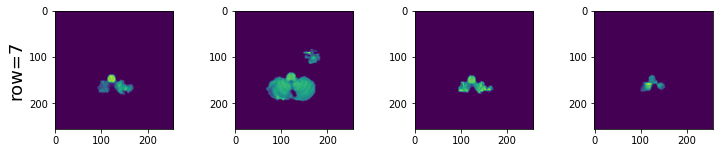

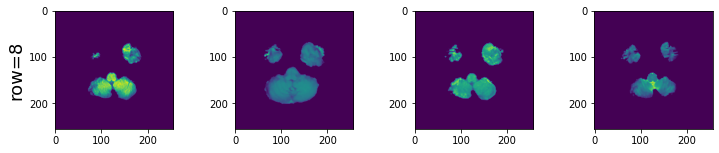

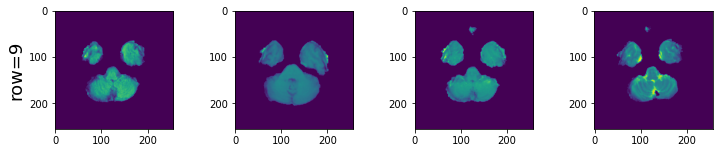

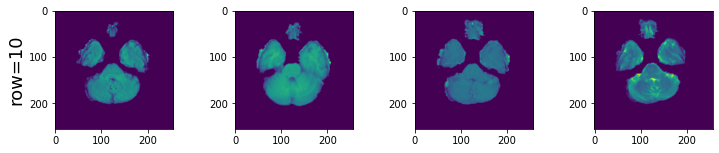

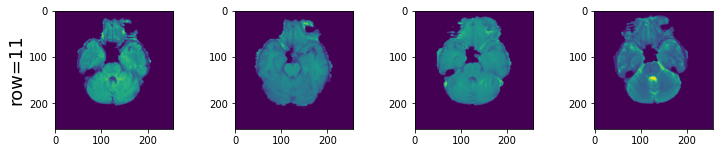

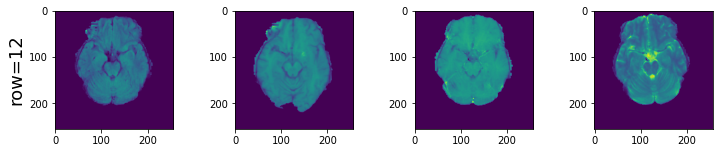

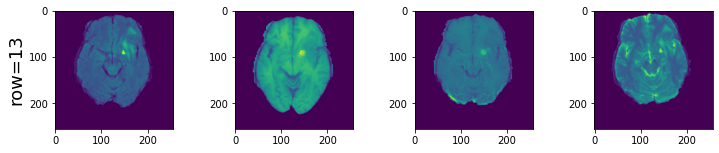

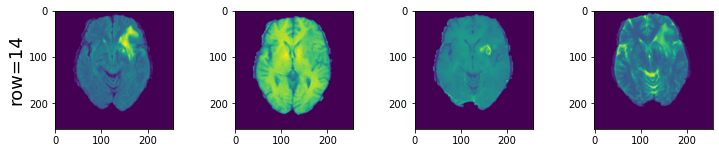

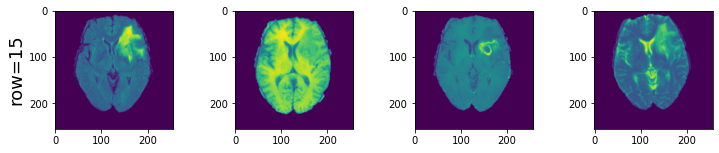

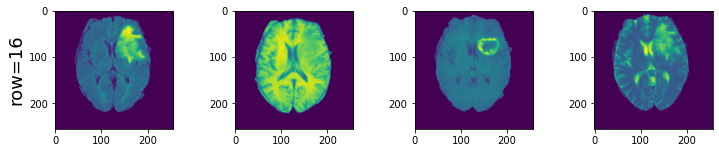

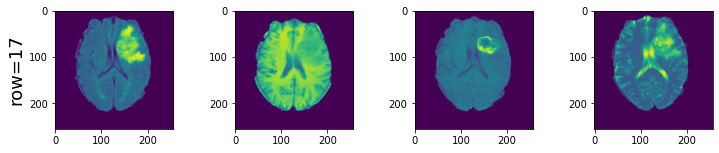

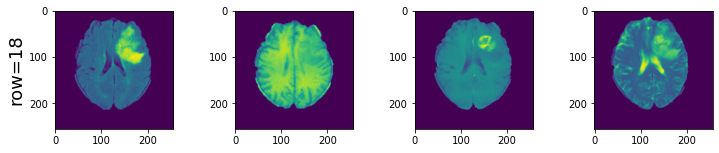

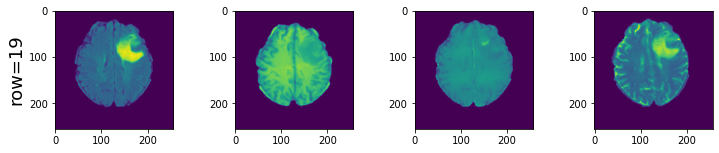

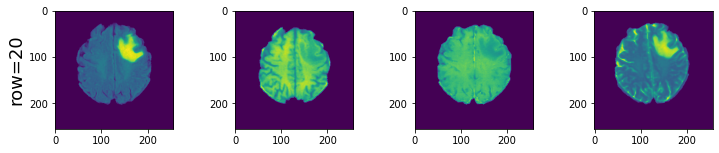

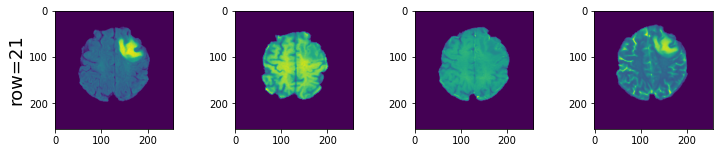

In [35]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))


for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

FLAIR etc. take the same position, but you can see that they look different.

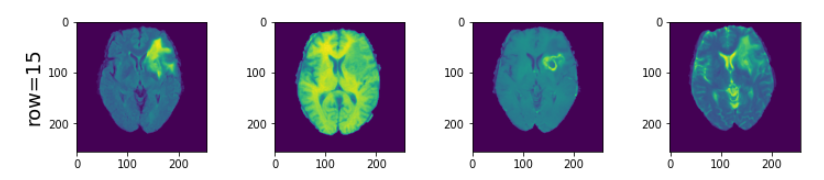

The upper right corner of this looks like a tumor

## **The one with MGMT_value = 0**
## Visualize the person who does not have gene methylation = those who do not have favorable prognostic and strong predictors of responsiveness to chemotherapy

MGMT_value = 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


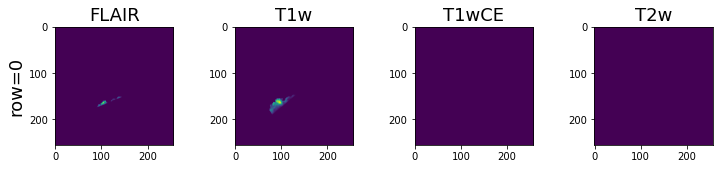

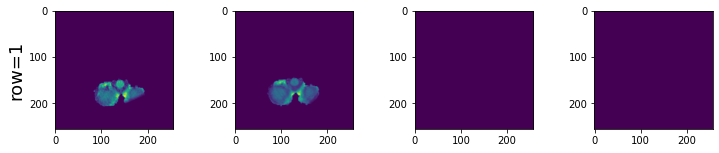

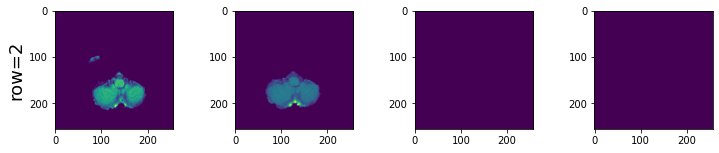

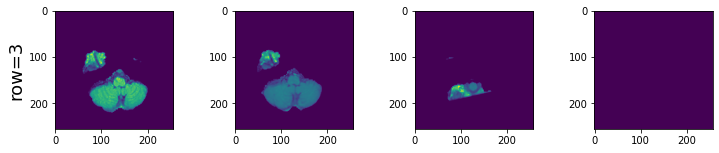

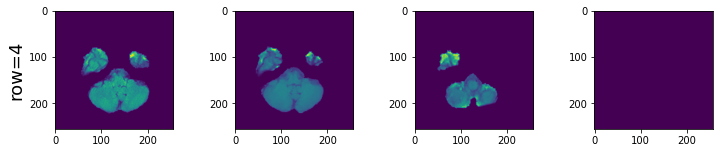

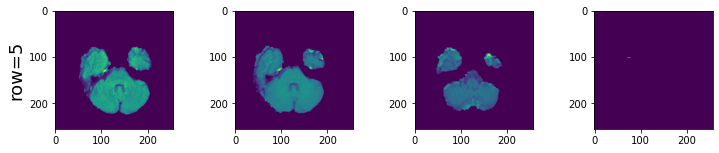

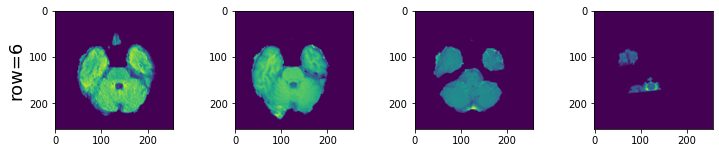

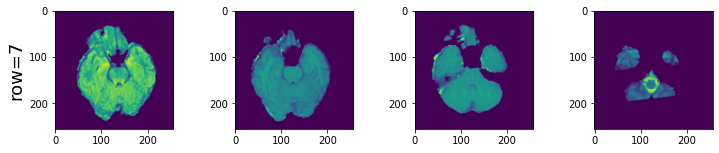

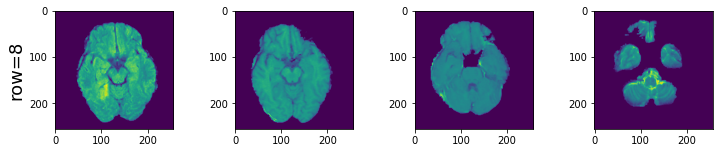

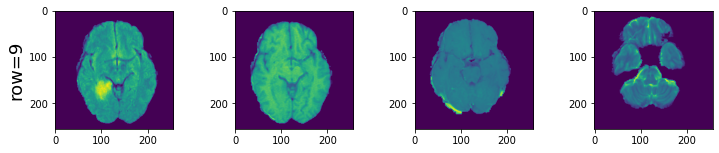

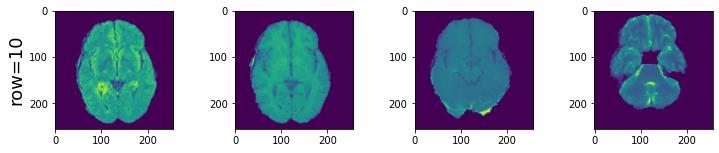

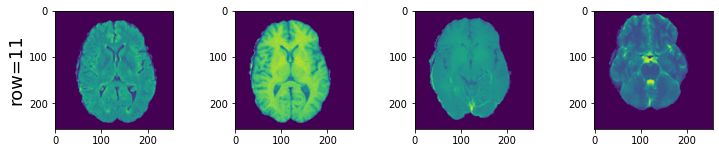

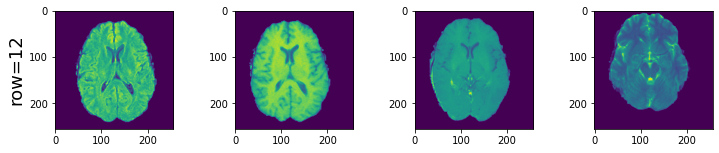

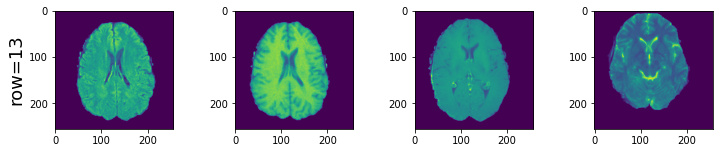

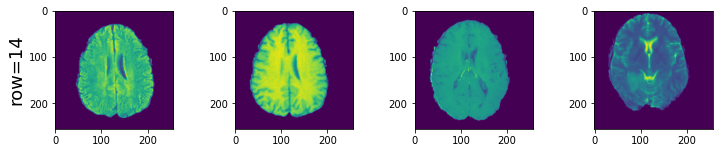

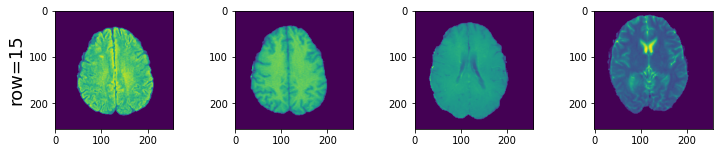

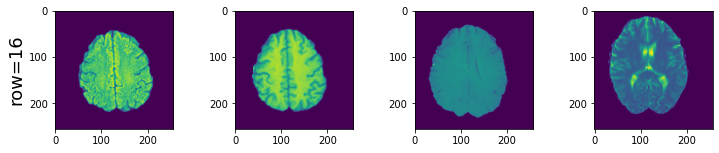

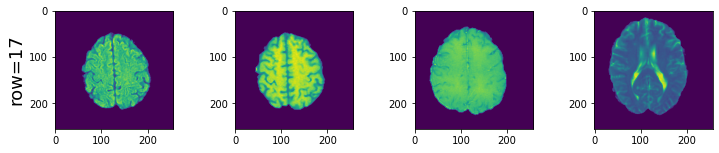

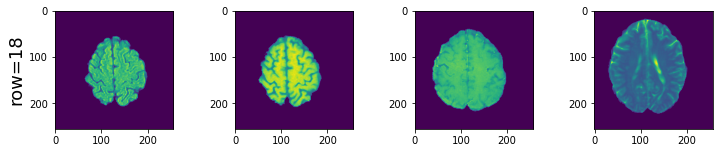

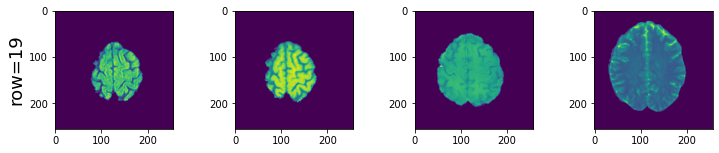

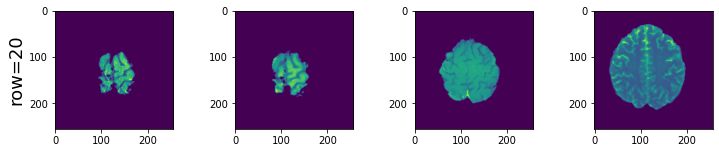

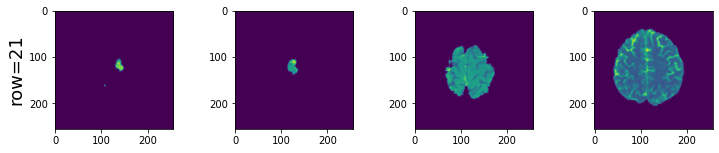

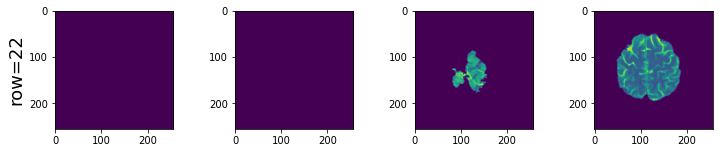

In [36]:
row_id = 65

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

This area ↓ is suspicious, but since this person is 0, methylation can not be found. There are few suspicious places as a whole. I guess we will also look at the test data from this information.

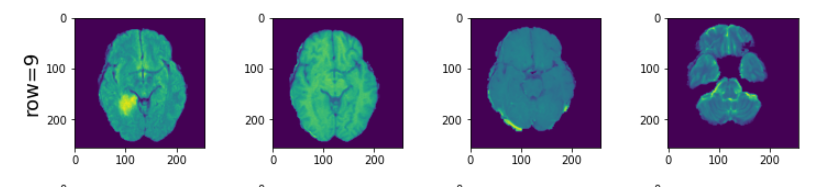

It's a quick glance, but the first and last ones are pitch black, so if you want to pick up a few, you might want to go to the middle.

## 2.5 When the number of files in each scan is not complete (this is about 90%)

When the number of data is not the same for 4 types, are the numbers the same in chronological order, or are they just serial numbers?
Let's look at the person with id = 0

In [37]:
train

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame
0,0,1,00000,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,33,129,408,False
1,2,1,00002,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,31,129,384,False
2,3,0,00003,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,33,129,408,False
3,5,1,00005,../input/rsna-miccai-brain-tumor-radiogenomic-...,400,28,129,424,False
4,6,1,00006,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,129,408,False
...,...,...,...,...,...,...,...,...,...
580,1005,1,01005,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True
581,1007,1,01007,../input/rsna-miccai-brain-tumor-radiogenomic-...,124,124,124,124,True
582,1008,1,01008,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,64,False
583,1009,0,01009,../input/rsna-miccai-brain-tumor-radiogenomic-...,23,23,23,23,True


Let's take a look at 33 images with pacient ID = 0 (because the number of T1w is 33, which is the smallest in the four Scans.)

In [38]:
row_id = 0

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [39]:
sampledf

,FLAIR_path,T1w_path,T1wCE_path,T2w_path
0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
...,...,...,...,...
395,../input/rsna-miccai-brain-tumor-radiogenomic-...,NaN,NaN,../input/rsna-miccai-brain-tumor-radiogenomic-...
396,../input/rsna-miccai-brain-tumor-radiogenomic-...,NaN,NaN,../input/rsna-miccai-brain-tumor-radiogenomic-...
397,../input/rsna-miccai-brain-tumor-radiogenomic-...,NaN,NaN,../input/rsna-miccai-brain-tumor-radiogenomic-...
398,../input/rsna-miccai-brain-tumor-radiogenomic-...,NaN,NaN,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [40]:
sampledf["T1w_path"].iloc[32]

'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-33.dcm'

I confirmed that the bottom is Nan. The numbers are sorted in ascending order, and the 32nd line is 33th, so the file names are serial numbers.

MGMT_value = 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


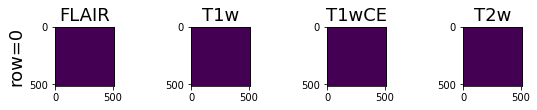

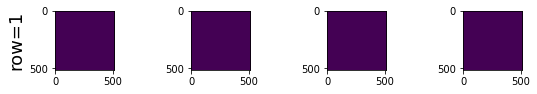

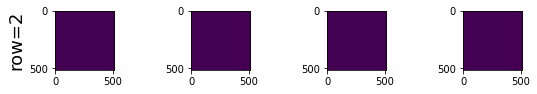

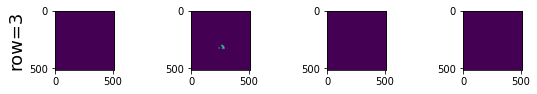

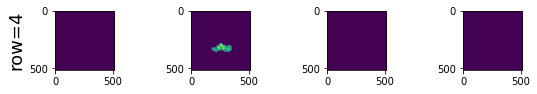

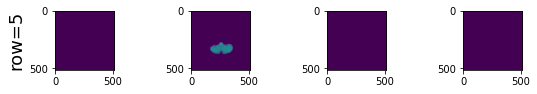

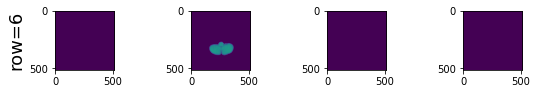

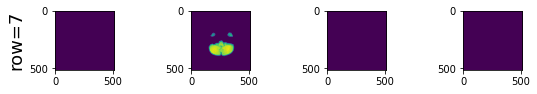

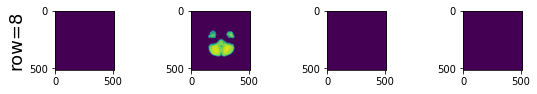

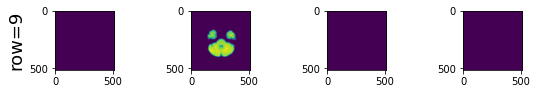

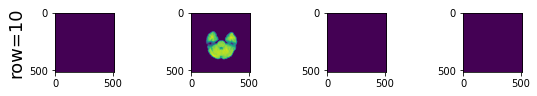

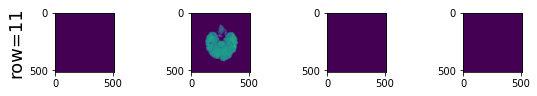

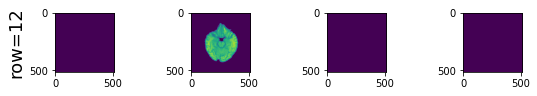

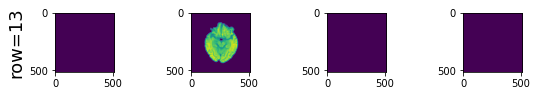

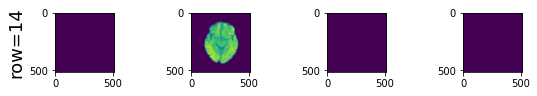

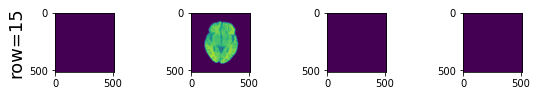

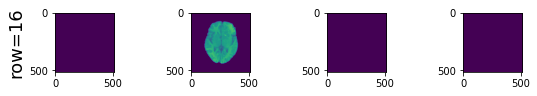

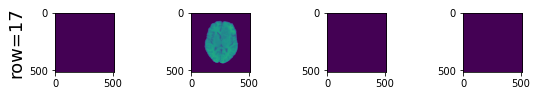

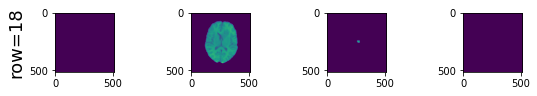

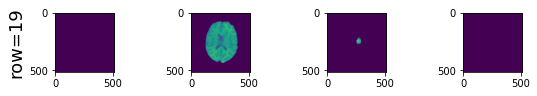

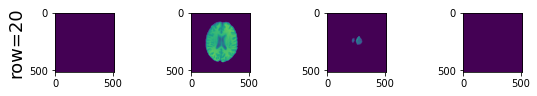

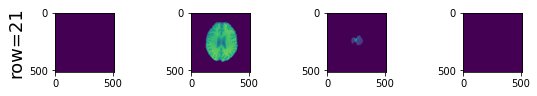

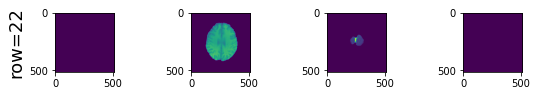

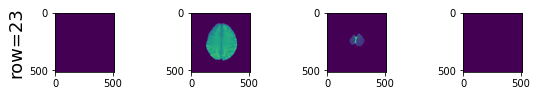

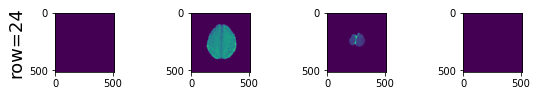

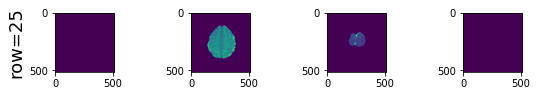

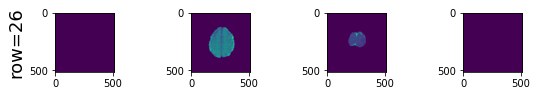

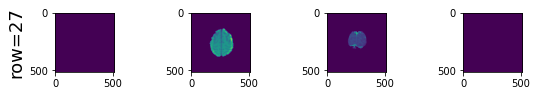

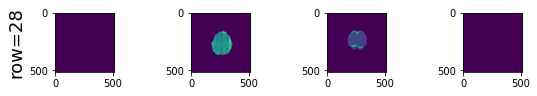

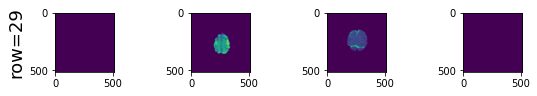

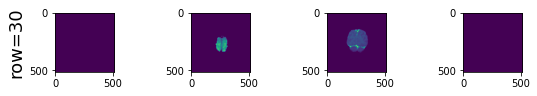

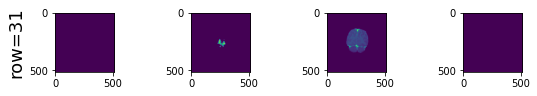

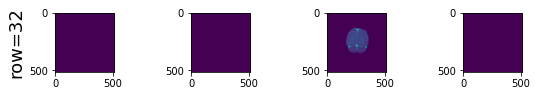

In [41]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(33):
    plt.figure(figsize=(80,5))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,33,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

T1W has only 33 images, but the timing is obviously off, so there seems to be a time difference between the file names.
It may be possible to get some other information from the dcm file (not yet investigated. I'm sorry).

# 3. Check how much the number of test data is the same.

The code is the same as the basic train, so I will put it together.

In [42]:
sample["imfolder"] = ['{0:05d}'.format(s) for s in sample["BraTS21ID"]]

test_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/test"

sample["path"] = [os.path.join(test_path,s) for s in sample["imfolder"]  ]


allres = []

for num,path in tqdm(enumerate(sample["path"])):
    for scan in Scans:
        folderpath = os.path.join(path,scan)
        filelist = os.listdir(folderpath)
        allres.append([sample["BraTS21ID"].iloc[num],scan,len(filelist)])

allnumdf = pd.DataFrame(allres)
allnumdf.columns=["BraTS21Id","scan","count"]
allnumdf

for scan in Scans:
    tmpdf = allnumdf[allnumdf["scan"]==scan].reset_index(drop=True)
    sample[scan + "_count"] = tmpdf["count"]

87it [00:09,  9.17it/s]


In [43]:
sample

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,1,0.5,00001,../input/rsna-miccai-brain-tumor-radiogenomic-...,208,32,129,129
1,13,0.5,00013,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,30,129,408
2,15,0.5,00015,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,408
3,27,0.5,00027,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,129
4,37,0.5,00037,../input/rsna-miccai-brain-tumor-radiogenomic-...,204,32,129,424
...,...,...,...,...,...,...,...,...
82,826,0.5,00826,../input/rsna-miccai-brain-tumor-radiogenomic-...,80,80,80,28
83,829,0.5,00829,../input/rsna-miccai-brain-tumor-radiogenomic-...,27,27,27,27
84,833,0.5,00833,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,34
85,997,0.5,00997,../input/rsna-miccai-brain-tumor-radiogenomic-...,36,36,36,36


In [44]:
allsame = [sample["FLAIR_count"].iloc[s] ==   sample["T1w_count"].iloc[s] ==sample["T1wCE_count"].iloc[s] ==sample["T2w_count"].iloc[s] 
          for s in range(len(sample))]

sample["allsame"] = allsame

sample

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame
0,1,0.5,00001,../input/rsna-miccai-brain-tumor-radiogenomic-...,208,32,129,129,False
1,13,0.5,00013,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,30,129,408,False
2,15,0.5,00015,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,408,False
3,27,0.5,00027,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,129,False
4,37,0.5,00037,../input/rsna-miccai-brain-tumor-radiogenomic-...,204,32,129,424,False
...,...,...,...,...,...,...,...,...,...
82,826,0.5,00826,../input/rsna-miccai-brain-tumor-radiogenomic-...,80,80,80,28,False
83,829,0.5,00829,../input/rsna-miccai-brain-tumor-radiogenomic-...,27,27,27,27,True
84,833,0.5,00833,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,34,False
85,997,0.5,00997,../input/rsna-miccai-brain-tumor-radiogenomic-...,36,36,36,36,True


In [45]:
sample["allsame"].sum()

11

In [46]:
sample["allsame"].sum()/len(sample) * 100

12.643678160919542

About 12% of the test data are available.

# 4. Submit


I want to change something as a test. For example, let's look at the tendency when the number of images is the same.

In [47]:
train.groupby("allsame")["MGMT_value"].mean().reset_index()

,allsame,MGMT_value
0,False,0.532567
1,True,0.460317


There seems to be a slight difference, so I will put it out with this.

In [48]:
sample["MGMT_value"] = np.where(sample["allsame"],0.460317,0.532567)

In [49]:
sample

,BraTS21ID,MGMT_value,imfolder,path,FLAIR_count,T1w_count,T1wCE_count,T2w_count,allsame
0,1,0.532567,00001,../input/rsna-miccai-brain-tumor-radiogenomic-...,208,32,129,129,False
1,13,0.532567,00013,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,30,129,408,False
2,15,0.532567,00015,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,408,False
3,27,0.532567,00027,../input/rsna-miccai-brain-tumor-radiogenomic-...,129,32,304,129,False
4,37,0.532567,00037,../input/rsna-miccai-brain-tumor-radiogenomic-...,204,32,129,424,False
...,...,...,...,...,...,...,...,...,...
82,826,0.532567,00826,../input/rsna-miccai-brain-tumor-radiogenomic-...,80,80,80,28,False
83,829,0.460317,00829,../input/rsna-miccai-brain-tumor-radiogenomic-...,27,27,27,27,True
84,833,0.532567,00833,../input/rsna-miccai-brain-tumor-radiogenomic-...,60,192,192,34,False
85,997,0.460317,00997,../input/rsna-miccai-brain-tumor-radiogenomic-...,36,36,36,36,True


In [50]:
sample= sample[["BraTS21ID","MGMT_value"]]

In [51]:
sample.to_csv("submission.csv",index=False)

In [52]:
sample

,BraTS21ID,MGMT_value
0,1,0.532567
1,13,0.532567
2,15,0.532567
3,27,0.532567
4,37,0.532567
...,...,...
82,826,0.532567
83,829,0.460317
84,833,0.532567
85,997,0.460317


# Thank you for watching until the end.

※Thank you to those who have uploaded to my notebook before.

# If you find it useful, I would be grateful if you could **upvote**!

※ At first, I misinterpreted this competition whether the people having or not having a brain tumor. 

I was pointed out in the English version. Thank you very much. 

And I'm sorry for those who were looking at the first version.
